In [1]:
# Import libraries
import numpy as np 
import pandas as pd 
# import seaborn as sns
import matplotlib.pyplot as plt
# import torch
# import torch.nn as nn
import lightgbm as lgb
# import torch
# import torch.nn as nn
# import torch.nn.functional as F
import warnings

from xgboost import XGBClassifier, plot_importance
from sklearn.model_selection import StratifiedKFold, StratifiedGroupKFold
# from sklearn.metrics import f1_score
# from sklearn.svm import SVC
from joblib import dump, load
# from sklearn.impute import SimpleImputer
# from tabpfn.scripts.transformer_prediction_interface import TabPFNClassifier
# from sklearn.decomposition import PCA
# from sklearn.preprocessing import normalize

warnings.filterwarnings("ignore")

In [2]:
# Load data
train=pd.read_csv('Transactions/train.csv')
test=pd.read_csv('Transactions/test.csv')
submission = test.loc[:, ['ID', 'Returned']].copy()

In [3]:
# Explore train data basics
len(train),len(train.OrderID.unique()),len(train.CustomerID.unique()),len(train.CustomerState.unique())

(64912, 21178, 6300, 51)

In [4]:
# Explore test data basics
len(test),len(test.OrderID.unique()),len(test.CustomerID.unique()),len(test.CustomerState.unique())

(14809, 4794, 3386, 51)

In [5]:
# Check how many customers in test set are in train set
count = 0
train_customer = set(train.CustomerID.unique())
for customer in test.CustomerID.unique():
    if customer in train_customer:
        count += 1
print(count)
# 3228 out of 3386 are return customers

3228


In [6]:
# Calculate return rate by state
return_rate_by_state = {}
for state in train.CustomerState.unique():
    return_rate = train.loc[train['CustomerState'] == state].describe().Returned['mean']
    return_rate_by_state[state] = return_rate
    
# Add StateReturnRate column to train and test data
train['StateReturnRate'] = train['CustomerState'].map(return_rate_by_state)
test['StateReturnRate'] = test['CustomerState'].map(return_rate_by_state)

In [7]:
# Add number of items in each order to train and test
import collections
ItemsInTheOrder = collections.Counter(train.OrderID)
train['ItemsInTheOrder'] = train['OrderID'].map(ItemsInTheOrder)
ItemsInTheOrder = collections.Counter(test.OrderID)
test['ItemsInTheOrder'] = test['OrderID'].map(ItemsInTheOrder)

In [8]:
# Add MSRP to train and test
train['MSRP'] = (train['PurchasePrice'] / (1 - train['DiscountPct'])).round()
test['MSRP'] = (test['PurchasePrice'] / (1 - test['DiscountPct'])).round()

In [9]:
# Add a column to indicate if the item's order has a same department item
def add_OrderHasSameDepartmentItem(train):
    train['OrderHasSameDepartmentItem'] = 0
    for OrderID in train.OrderID.unique():
        order = train.loc[train['OrderID'] == OrderID]
        if len(order) > 1:
            for i in range(len(order) - 1):
                item = order.iloc[[i]]
                for j in range(i + 1, len(order)):
                    other_item = order.iloc[[j]]
                    if item['ProductDepartment'].iloc[0] == other_item['ProductDepartment'].iloc[0]:
                        train.loc[item.index[0], 'OrderHasSameDepartmentItem'] = 1
                        train.loc[other_item.index[0], 'OrderHasSameDepartmentItem'] = 1
add_OrderHasSameDepartmentItem(train)
add_OrderHasSameDepartmentItem(test)

In [10]:
# Add a column to indicate if the item's order has a same MSRP item
def add_OrderHasSameMSRPItem(train):
    train['OrderHasSameMSRPItem'] = 0
    for OrderID in train.OrderID.unique():
        order = train.loc[train['OrderID'] == OrderID]
        if len(order) > 1:
            for i in range(len(order) - 1):
                item = order.iloc[[i]]
                for j in range(i + 1, len(order)):
                    other_item = order.iloc[[j]]
                    if item['MSRP'].iloc[0] == other_item['MSRP'].iloc[0]:
                        train.loc[item.index[0], 'OrderHasSameMSRPItem'] = 1
                        train.loc[other_item.index[0], 'OrderHasSameMSRPItem'] = 1
add_OrderHasSameMSRPItem(train)
add_OrderHasSameMSRPItem(test)

In [11]:
# Calculate return rate by customer
return_rate_by_customer = {}
for customer in train.CustomerID.unique():
    return_rate = train.loc[train['CustomerID'] == customer].describe().Returned['mean']
    return_rate_by_customer[customer] = return_rate
    
# Add CustomerReturnRate column to train and test
train['CustomerReturnRate'] = train['CustomerID'].map(return_rate_by_customer)
test['CustomerReturnRate'] = train.describe().Returned['mean'] # add average return rate for new customer
for i in range(len(test)):
    if test.iloc[i].CustomerID in return_rate_by_customer:
        test.loc[i, 'CustomerReturnRate'] = return_rate_by_customer[test.iloc[i].CustomerID]

In [12]:
# Convert CustomerBirthDate and OrderDate from object data type to datetime datatype
def convert_datetime(train):
    train['CustomerBirthDate'] = pd.to_datetime(train['CustomerBirthDate'])
    train['OrderDate'] = pd.to_datetime(train['OrderDate'])
convert_datetime(train)
convert_datetime(test)

# Add customer age when placing the order
def add_CustomerAgeWhenPlacingOrder(train):
    train['CustomerAgeWhenPlacingOrder'] = ((train['OrderDate'] - train['CustomerBirthDate']) / np.timedelta64(1, 'Y')).astype(int)
add_CustomerAgeWhenPlacingOrder(train)
add_CustomerAgeWhenPlacingOrder(test)

In [13]:
# Add date of the year when placing the order
def add_OrderDayOfYear(train):
    train['OrderDayOfYear'] = train['OrderDate'].dt.dayofyear
add_OrderDayOfYear(train)
add_OrderDayOfYear(test)

In [14]:
# Calculate return rate by department
return_rate_by_department = {}
for department in train.ProductDepartment.unique():
    return_rate = train.loc[train['ProductDepartment'] == department].describe().Returned['mean']
    return_rate_by_department[department] = return_rate
print(return_rate_by_department)
# Return rate is quite different between departments

{'Youth': 0.26533186189500235, 'Mens': 0.3721610398988987, 'Womens': 0.3857068568457024, 'Accessories': 0.12727732793522267}


In [15]:
# Calculate return rate by product size
return_rate_by_size = {}
for size in train.ProductSize.unique():
    return_rate = train.loc[train['ProductSize'] == size].describe().Returned['mean']
    return_rate_by_size[size] = return_rate
print(return_rate_by_size)
# Return rate is very similar for different sizes except '~', which is accessories.

{'M': 0.35770202798495965, 'L': 0.3647214854111406, 'XL': 0.38111336488618436, 'XS': 0.35988538681948423, 'XXL': 0.39212093449381585, 'S': 0.3662394045896217, '~': 0.12727732793522267}


In [16]:
# One hot enconding of ProductDepartment and ProductSize
train = pd.get_dummies(train, columns = ['ProductDepartment', 'ProductSize'], dtype = int)
test = pd.get_dummies(test, columns = ['ProductDepartment', 'ProductSize'], dtype = int)

In [17]:
# Drop 'ID', 'OrderID', 'CustomerID', 'CustomerState', 'CustomerBirthDate', 'OrderDate'
train.drop(['ID', 'OrderID', 'CustomerID', 'CustomerState', 'CustomerBirthDate', 'OrderDate'], axis=1, inplace = True)
test.drop(['ID', 'OrderID', 'CustomerID', 'CustomerState', 'CustomerBirthDate', 'OrderDate'], axis=1, inplace = True)

In [18]:
# Prepare features and target for training
FEATURES = train.drop('Returned', axis = 1).columns.tolist()
def get_training_data(df):
    x = df.drop('Returned', axis = 1).to_numpy()
    
    y = df['Returned'].to_numpy()
    y = y[:]
    
    return x, y

X, y = get_training_data(train)
print(X.shape)
print(y.shape)

(64912, 22)
(64912,)


In [19]:
# Prepare loss metrics for xgboost and lightgbm models
def balanced_log_loss(y_true, y_pred):
    # y_true: correct labels 0, 1
    # y_pred: predicted probabilities of class = 1
    # calculate the number of observations for each class
    N_0 = np.sum(1 - y_true)
    N_1 = np.sum(y_true)
    # calculate the weights for each class to balance classes
    w_0 = 1 / N_0
    w_1 = 1 / N_1
    # calculate the predicted probabilities for each class
    p_1 = np.clip(y_pred, 1e-15, 1 - 1e-15)
    p_0 = 1 - p_1
    # calculate the summed log loss for each class
    log_loss_0 = -np.sum((1 - y_true) * np.log(p_0))
    log_loss_1 = -np.sum(y_true * np.log(p_1))
    # calculate the weighted summed logarithmic loss
    # (factgor of 2 included to give same result as LL with balanced input)
    balanced_log_loss = 2*(w_0 * log_loss_0 + w_1 * log_loss_1) / (w_0 + w_1)
    # return the average log loss
    return balanced_log_loss/(N_0+N_1)

def lgbm_balanced_log_loss(y_true, y_pred):
    # y_true: correct labels 0, 1
    # y_pred: predicted probabilities of class=1
    # calculate the number of observations for each class
    N_0 = np.sum(1 - y_true)
    N_1 = np.sum(y_true)
    # calculate the weights for each class to balance classes
    w_0 = 1 / N_0
    w_1 = 1 / N_1
    # calculate the predicted probabilities for each class
    p_1 = np.clip(y_pred, 1e-15, 1 - 1e-15)
    p_0 = 1 - p_1
    # calculate the summed log loss for each class
    log_loss_0 = -np.sum((1 - y_true) * np.log(p_0))
    log_loss_1 = -np.sum(y_true * np.log(p_1))
    # calculate the weighted summed logarithmic loss
    # (factgor of 2 included to give same result as LL with balanced input)
    balanced_log_loss = 2*(w_0 * log_loss_0 + w_1 * log_loss_1) / (w_0 + w_1)
    avg_log_loss = balanced_log_loss/(N_0+N_1)
    # return the average log loss
    return "balanced_log_loss", avg_log_loss, False

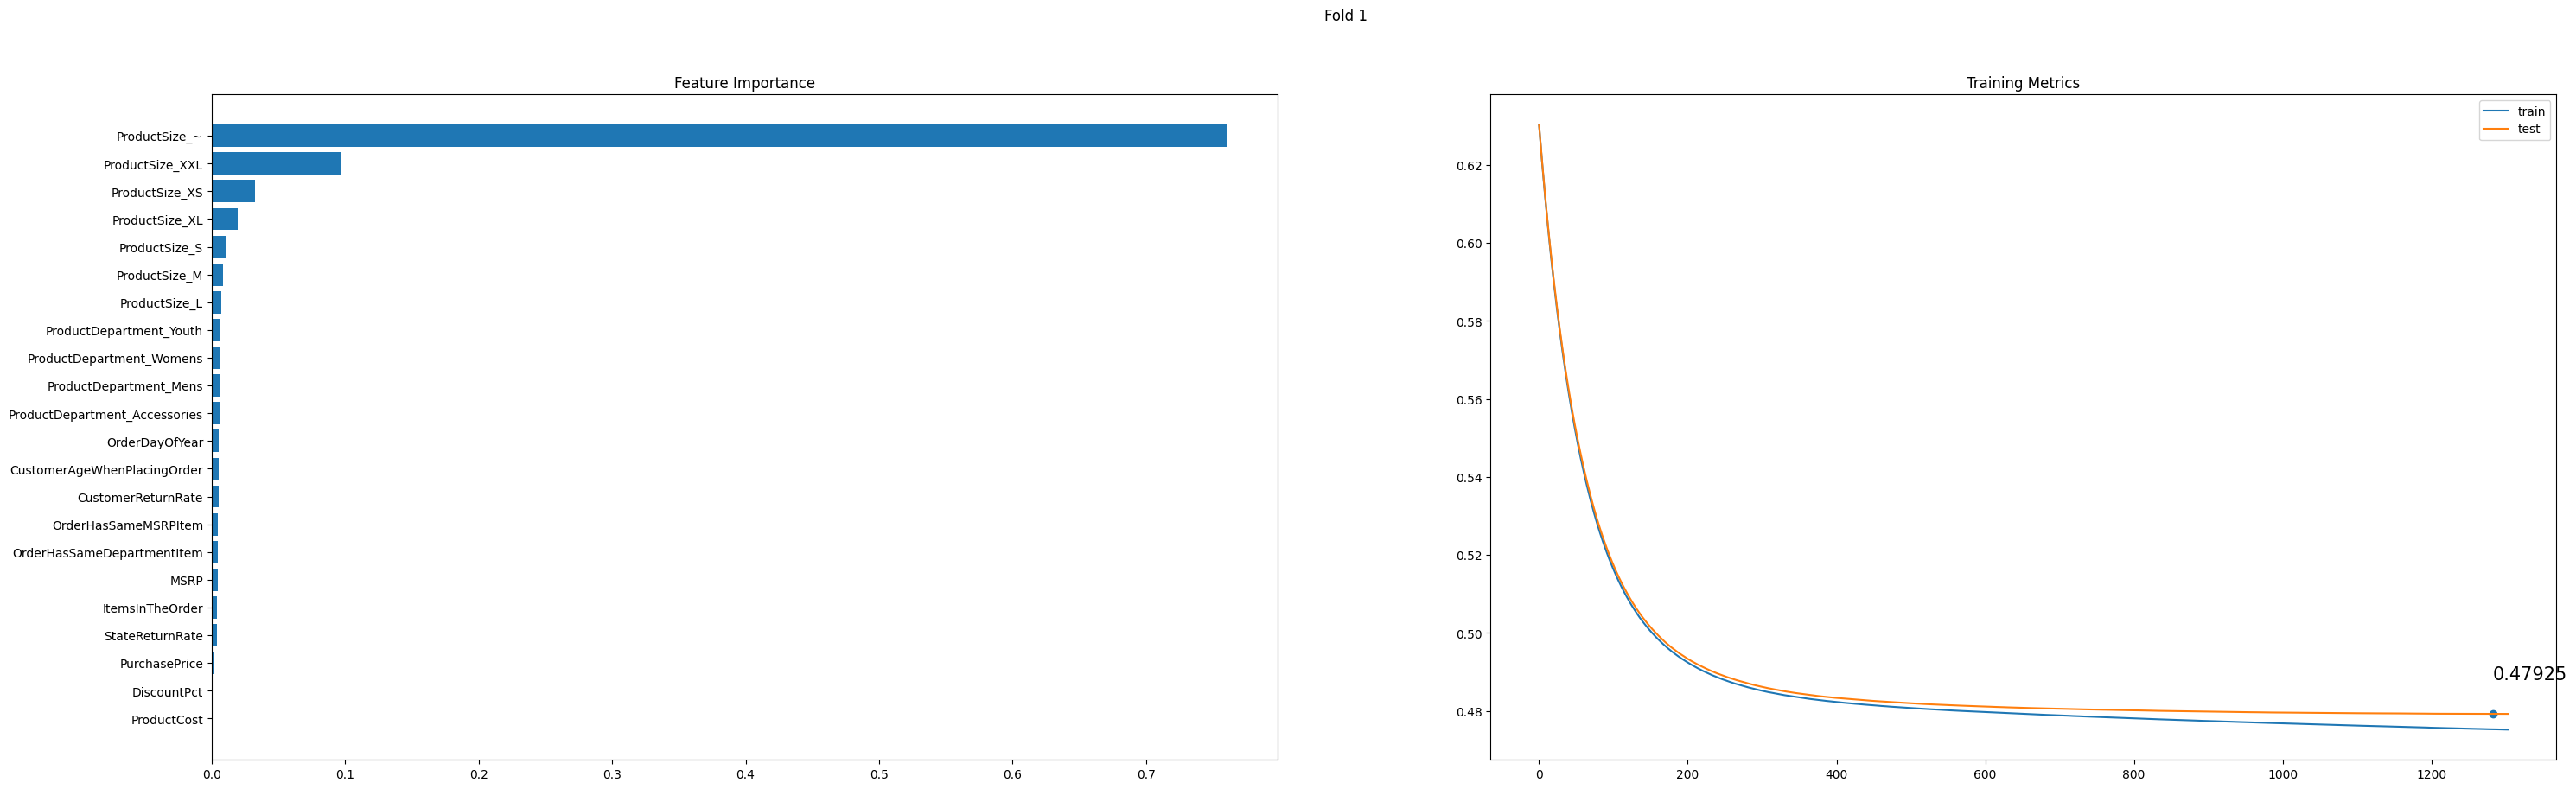

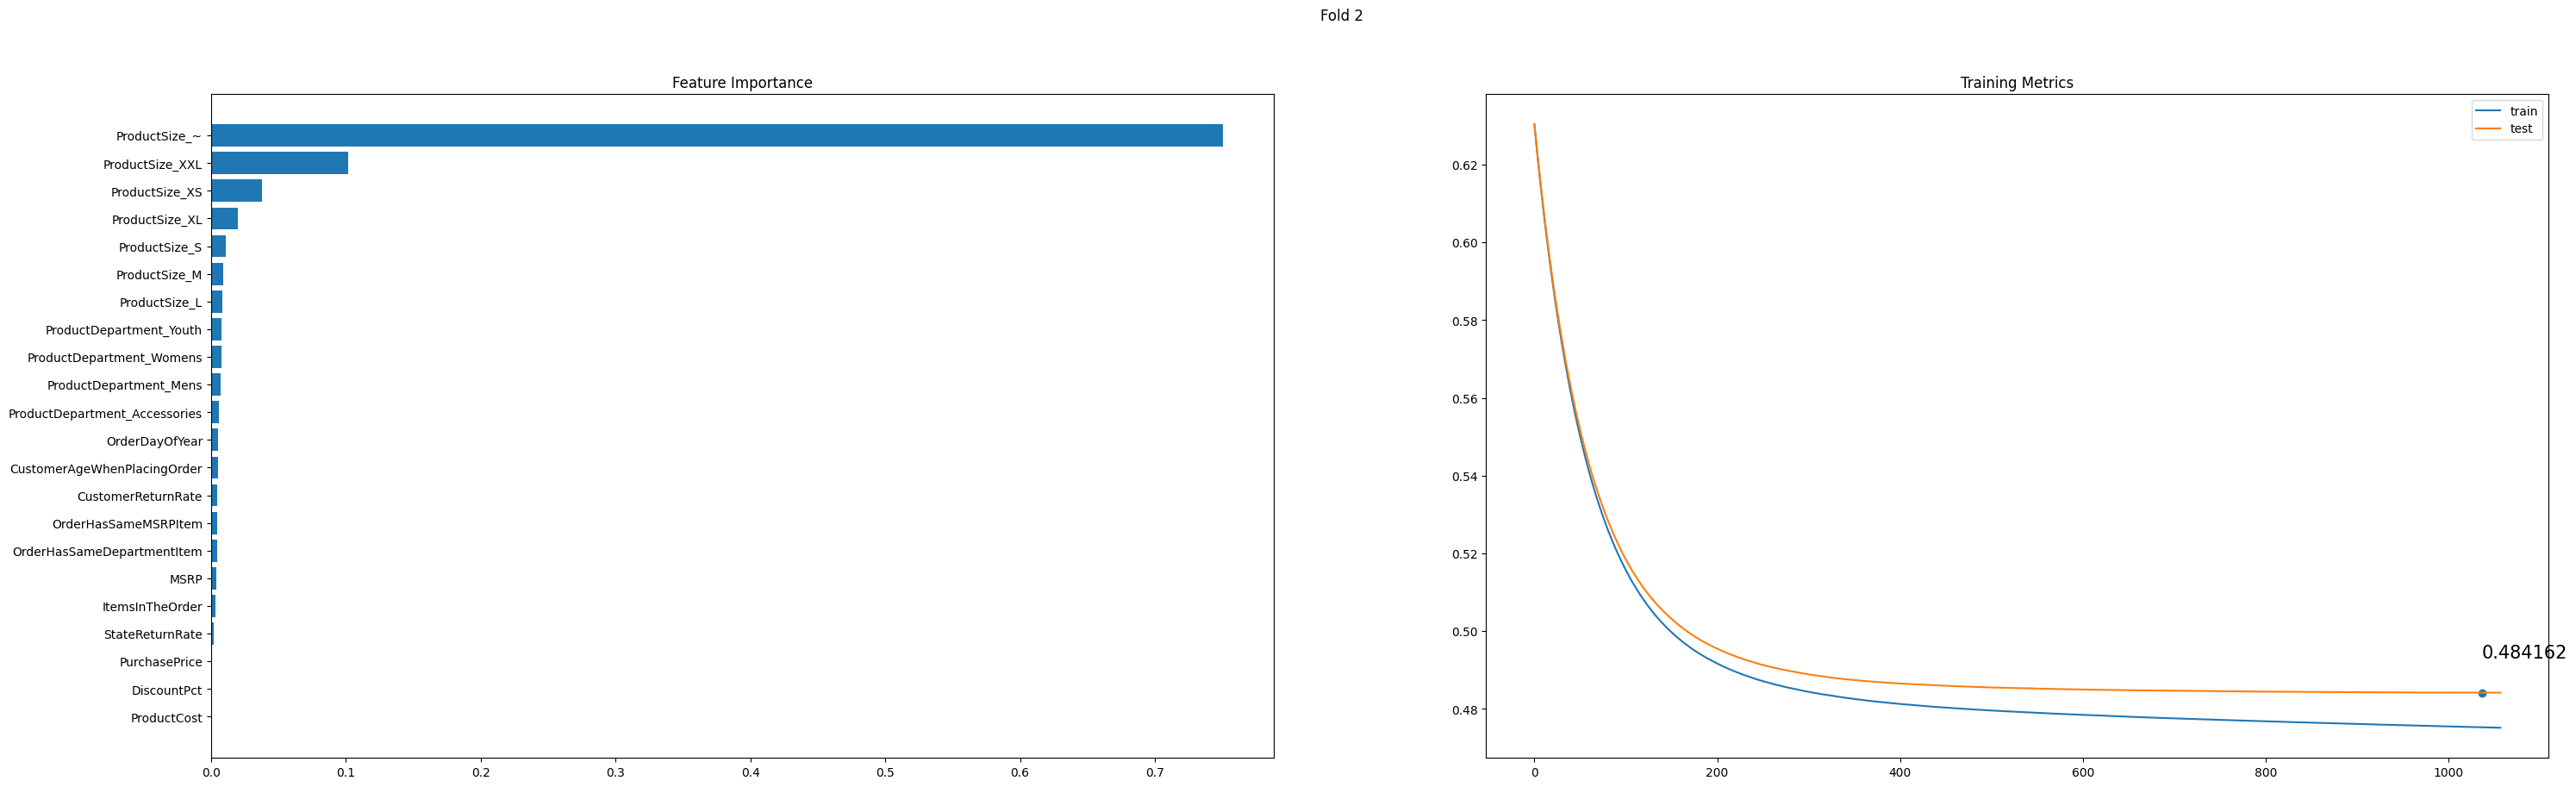

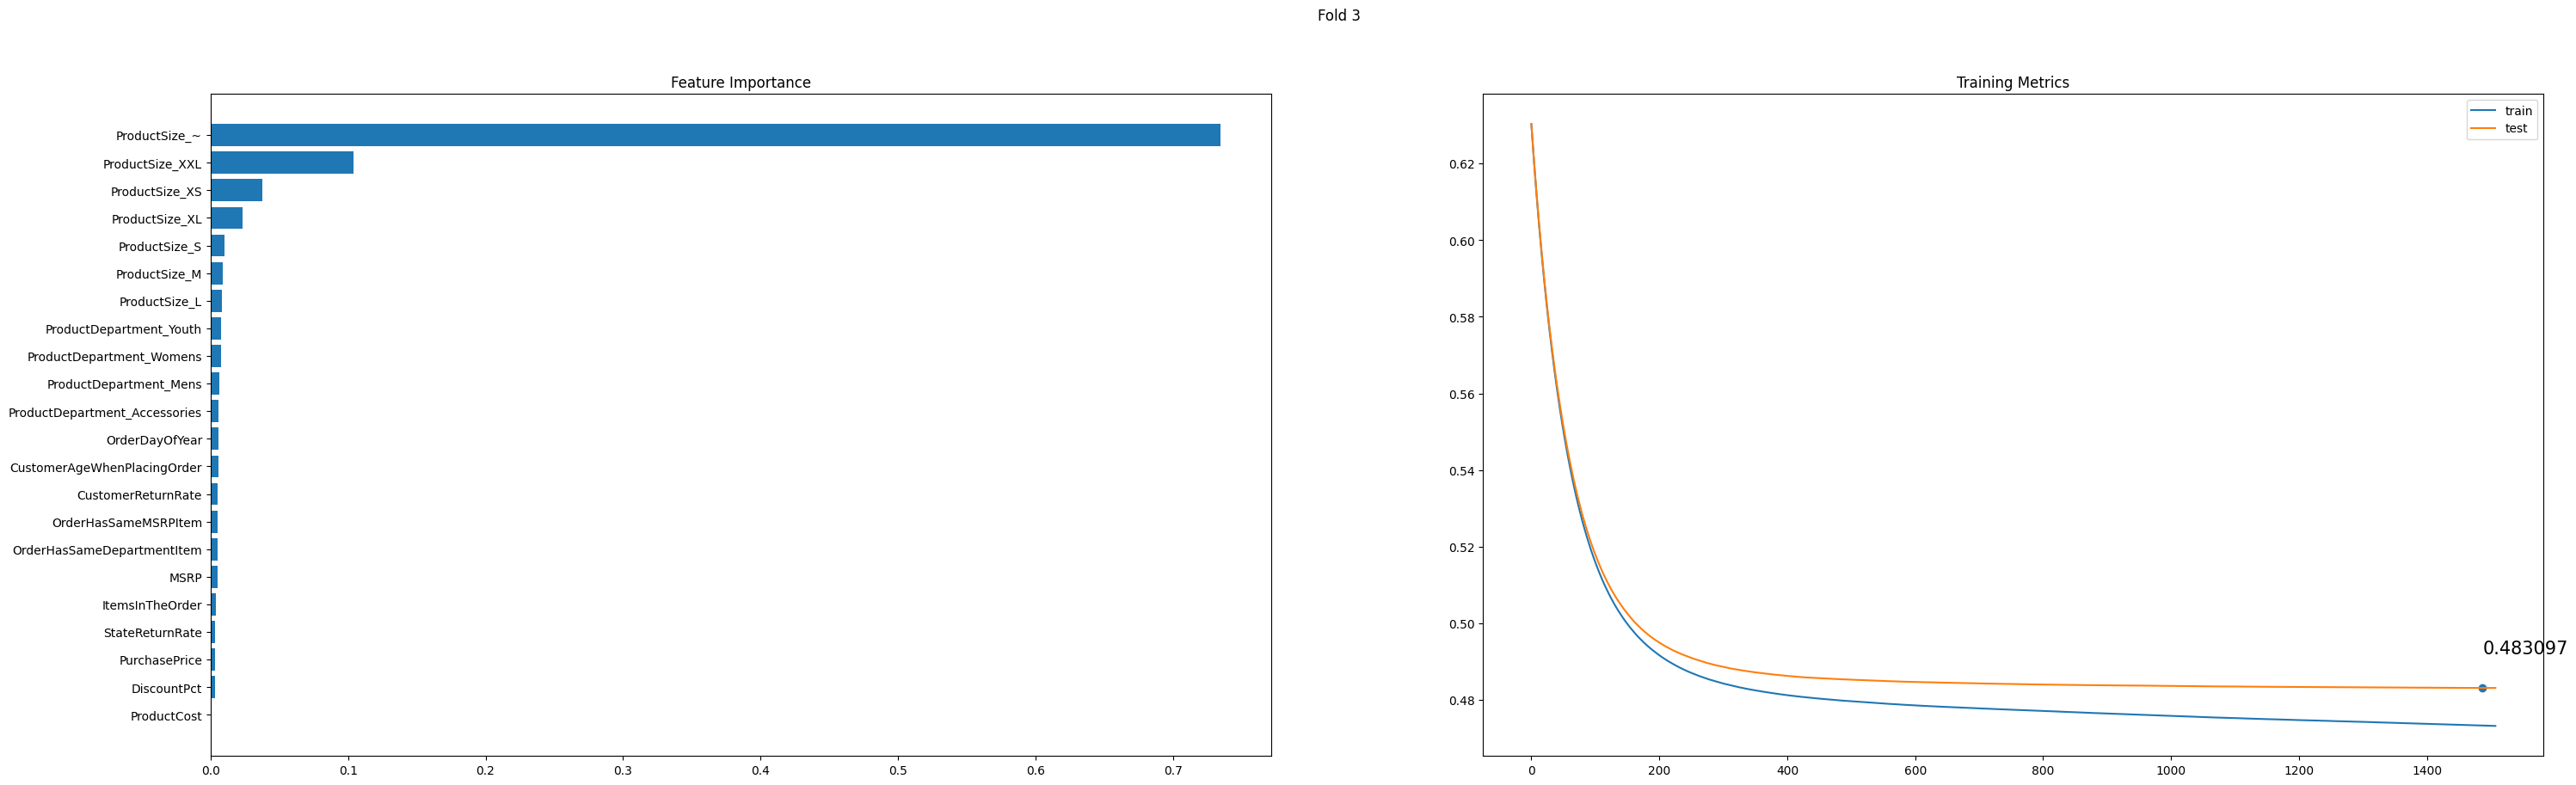

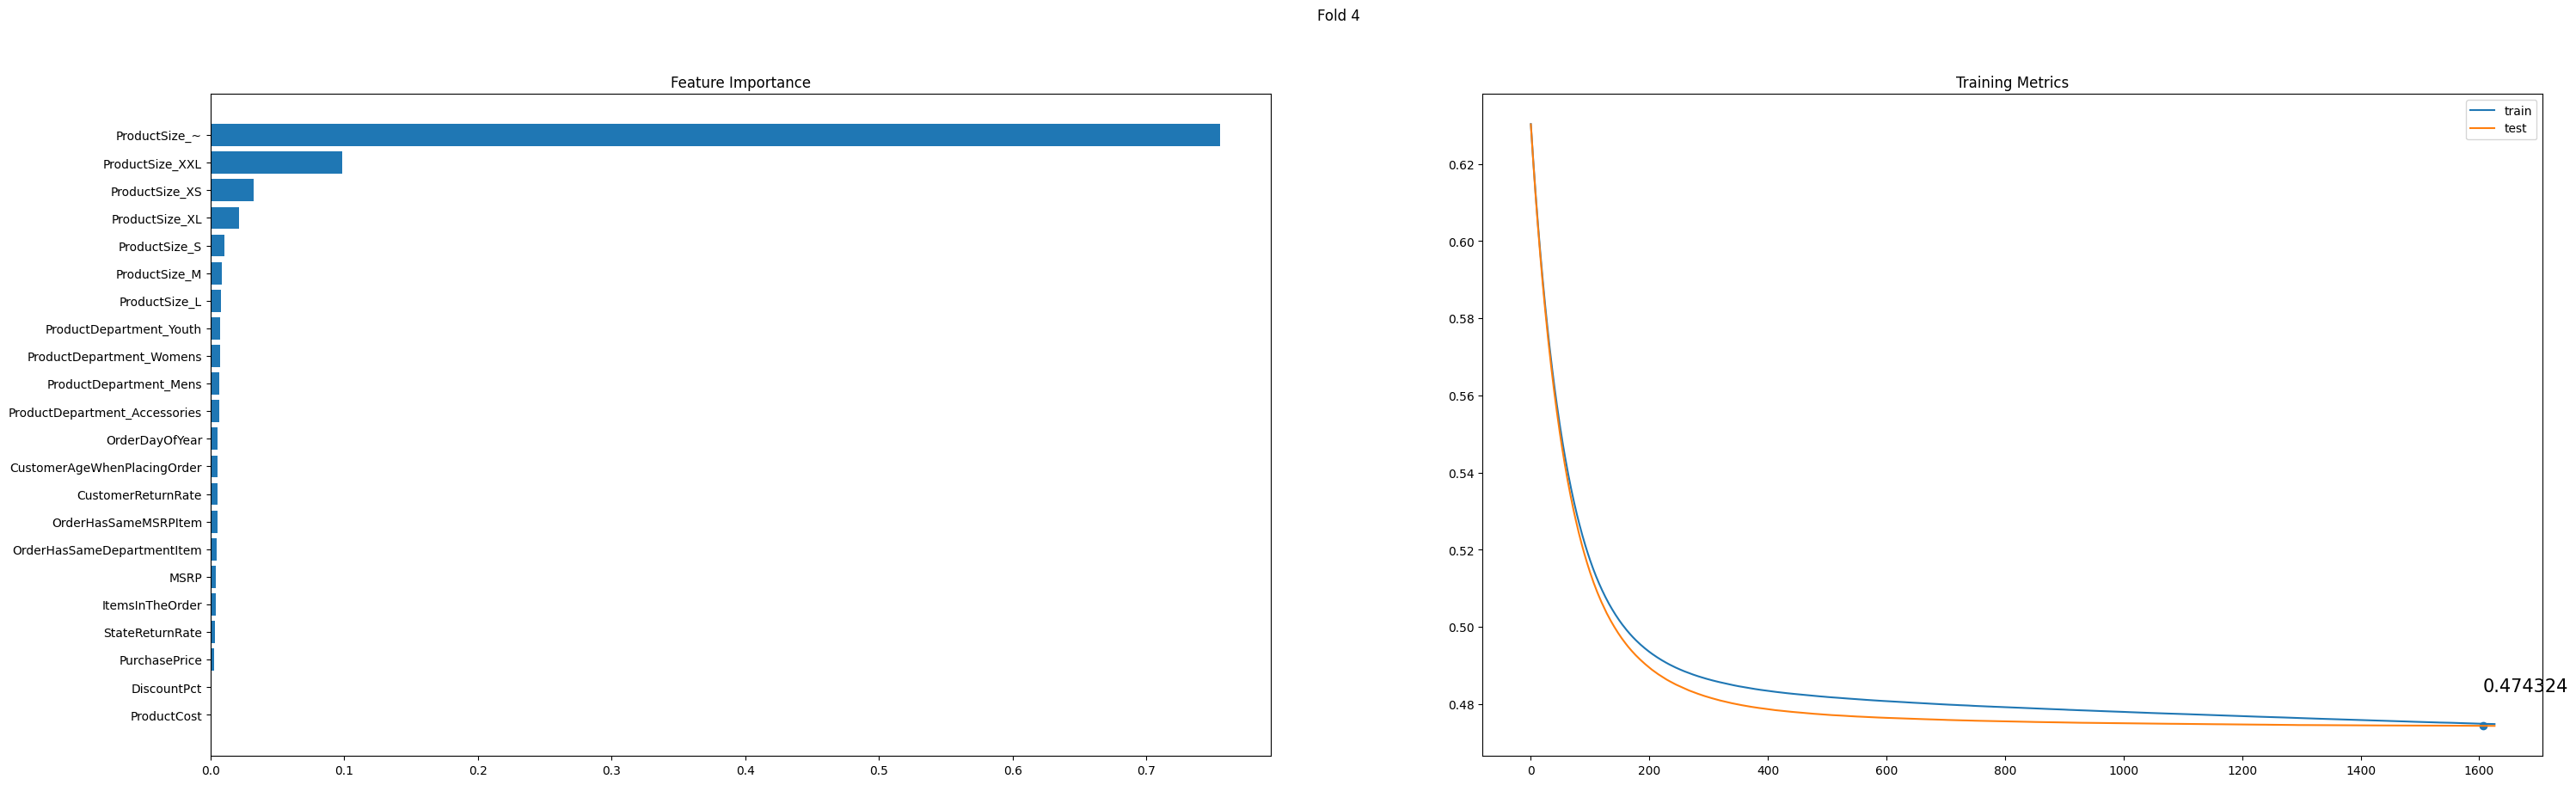

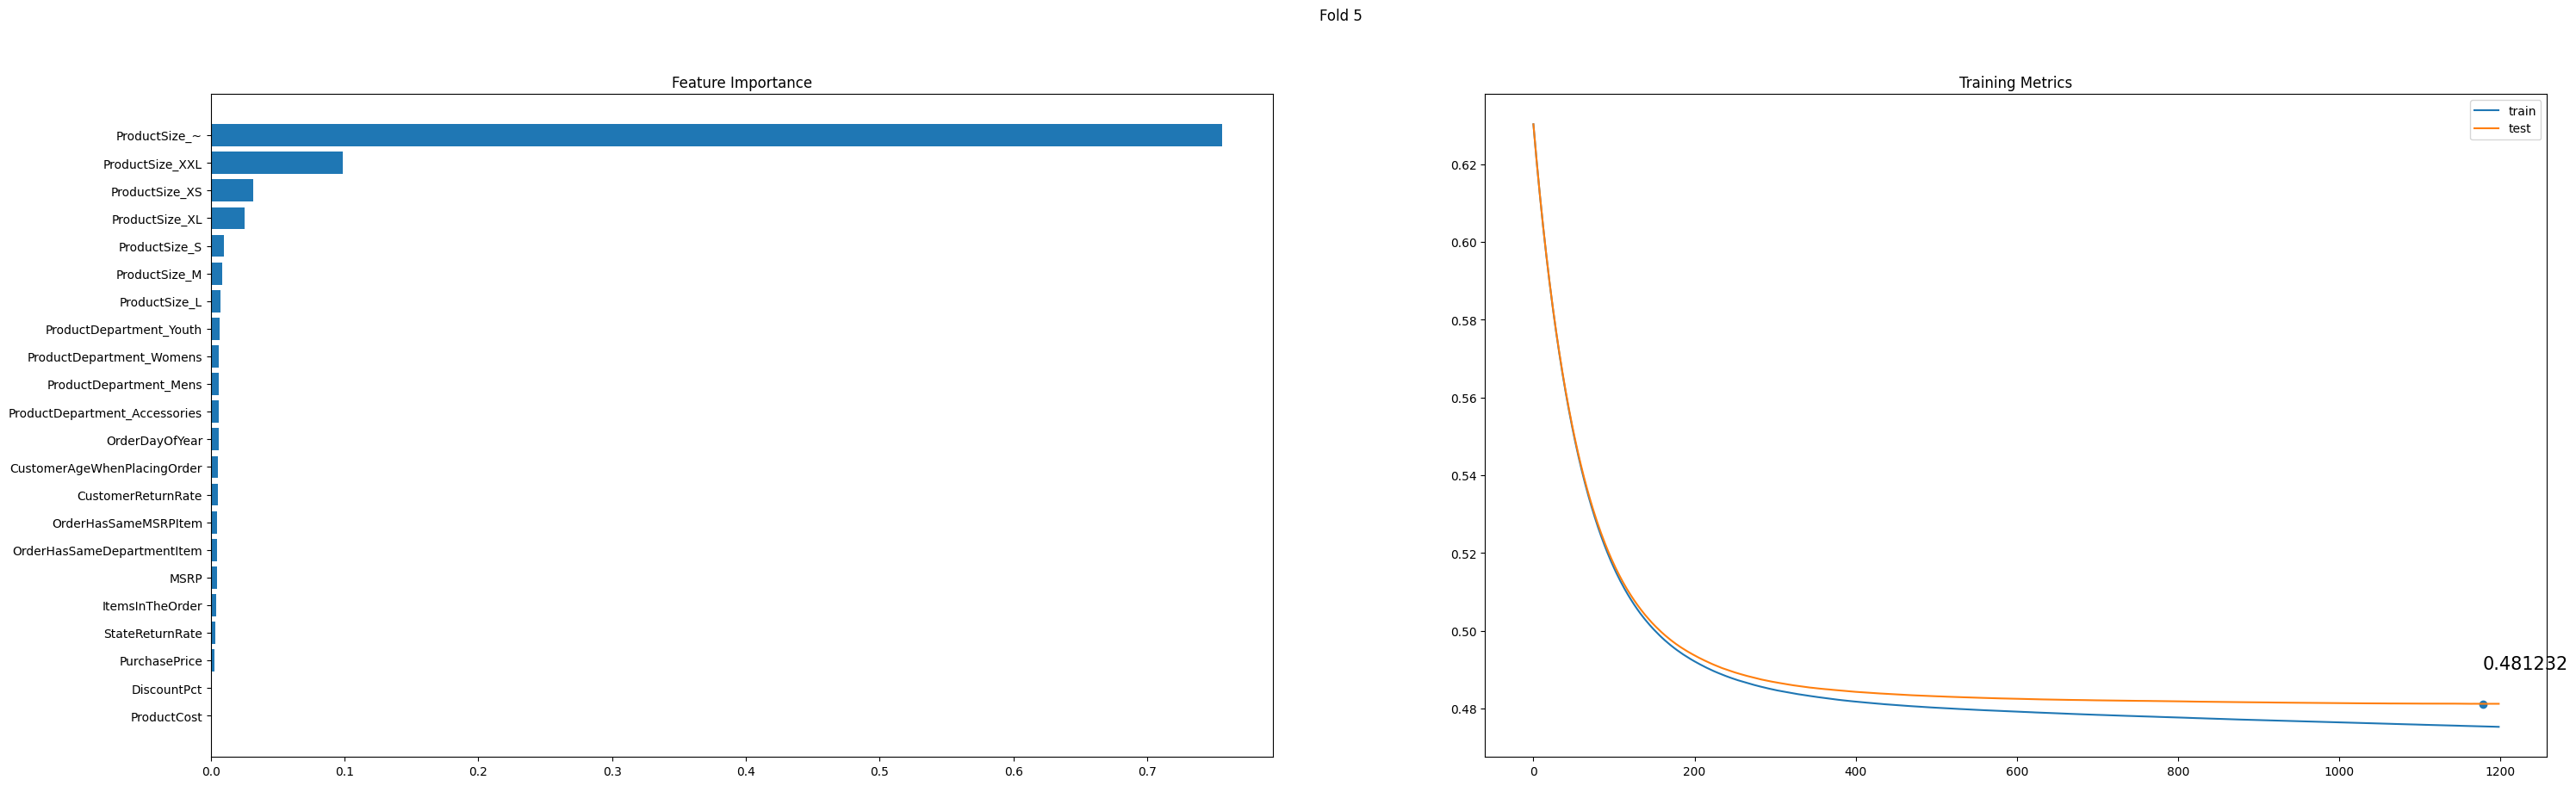

0.474324


In [20]:
def train_xgb(X, y):
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    best_score = np.inf  
    
    for i, (train_index, test_index) in enumerate(skf.split(X, y)):
        X_train, y_train = X[train_index], y[train_index]
        X_val, y_val = X[test_index], y[test_index]
        
        unique, counts = np.unique(y_train, return_counts=True)
        scale_pos_weight = counts[0]/counts[1]
        
        model = XGBClassifier(n_estimators=5000,
                              eta=0.01,
                              max_depth=3,
                              scale_pos_weight=scale_pos_weight,
                              early_stopping_rounds=20, 
                              objective='binary:logistic',
                              eval_metric=balanced_log_loss
        )

        model.fit(X_train, y_train,
                  eval_set=[(X_train, y_train), (X_val, y_val)],
                  verbose=0
        )

        results = model.evals_result()

        best_iteration = model.get_booster().best_iteration
        min_score = results['validation_1']['balanced_log_loss'][best_iteration]

        if min_score < best_score:
            best_score = min_score
            dump(model, 'xgb.sav')

        fig ,axs = plt.subplots(1, 2, figsize=(35, 10))
        fig.suptitle(f'Fold {i+1}')

        sorted_idx = model.feature_importances_.argsort()
        axs[0].barh(FEATURES, model.feature_importances_[sorted_idx])
        axs[0].set_title('Feature Importance')
        
        metric_score = min(results['validation_1']['balanced_log_loss'])
        metric_index = results['validation_1']['balanced_log_loss'].index(min(results['validation_1']['balanced_log_loss']))

        axs[1].plot(results['validation_0']['balanced_log_loss'], label='train')
        axs[1].plot(results['validation_1']['balanced_log_loss'], label='test')

        axs[1].scatter(x=metric_index, y=metric_score)
        axs[1].text(metric_index, metric_score+0.008, str(metric_score), va='bottom', fontsize=15)
        axs[1].set_title(f'Training Metrics')
        axs[1].legend()

        plt.show()
        
    return best_score
xgb_best_score = train_xgb(X, y)
print(xgb_best_score)

[LightGBM] [Info] Number of positive: 18301, number of negative: 33628
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005416 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1121
[LightGBM] [Info] Number of data points in the train set: 51929, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.352424 -> initscore=-0.608403
[LightGBM] [Info] Start training from score -0.608403


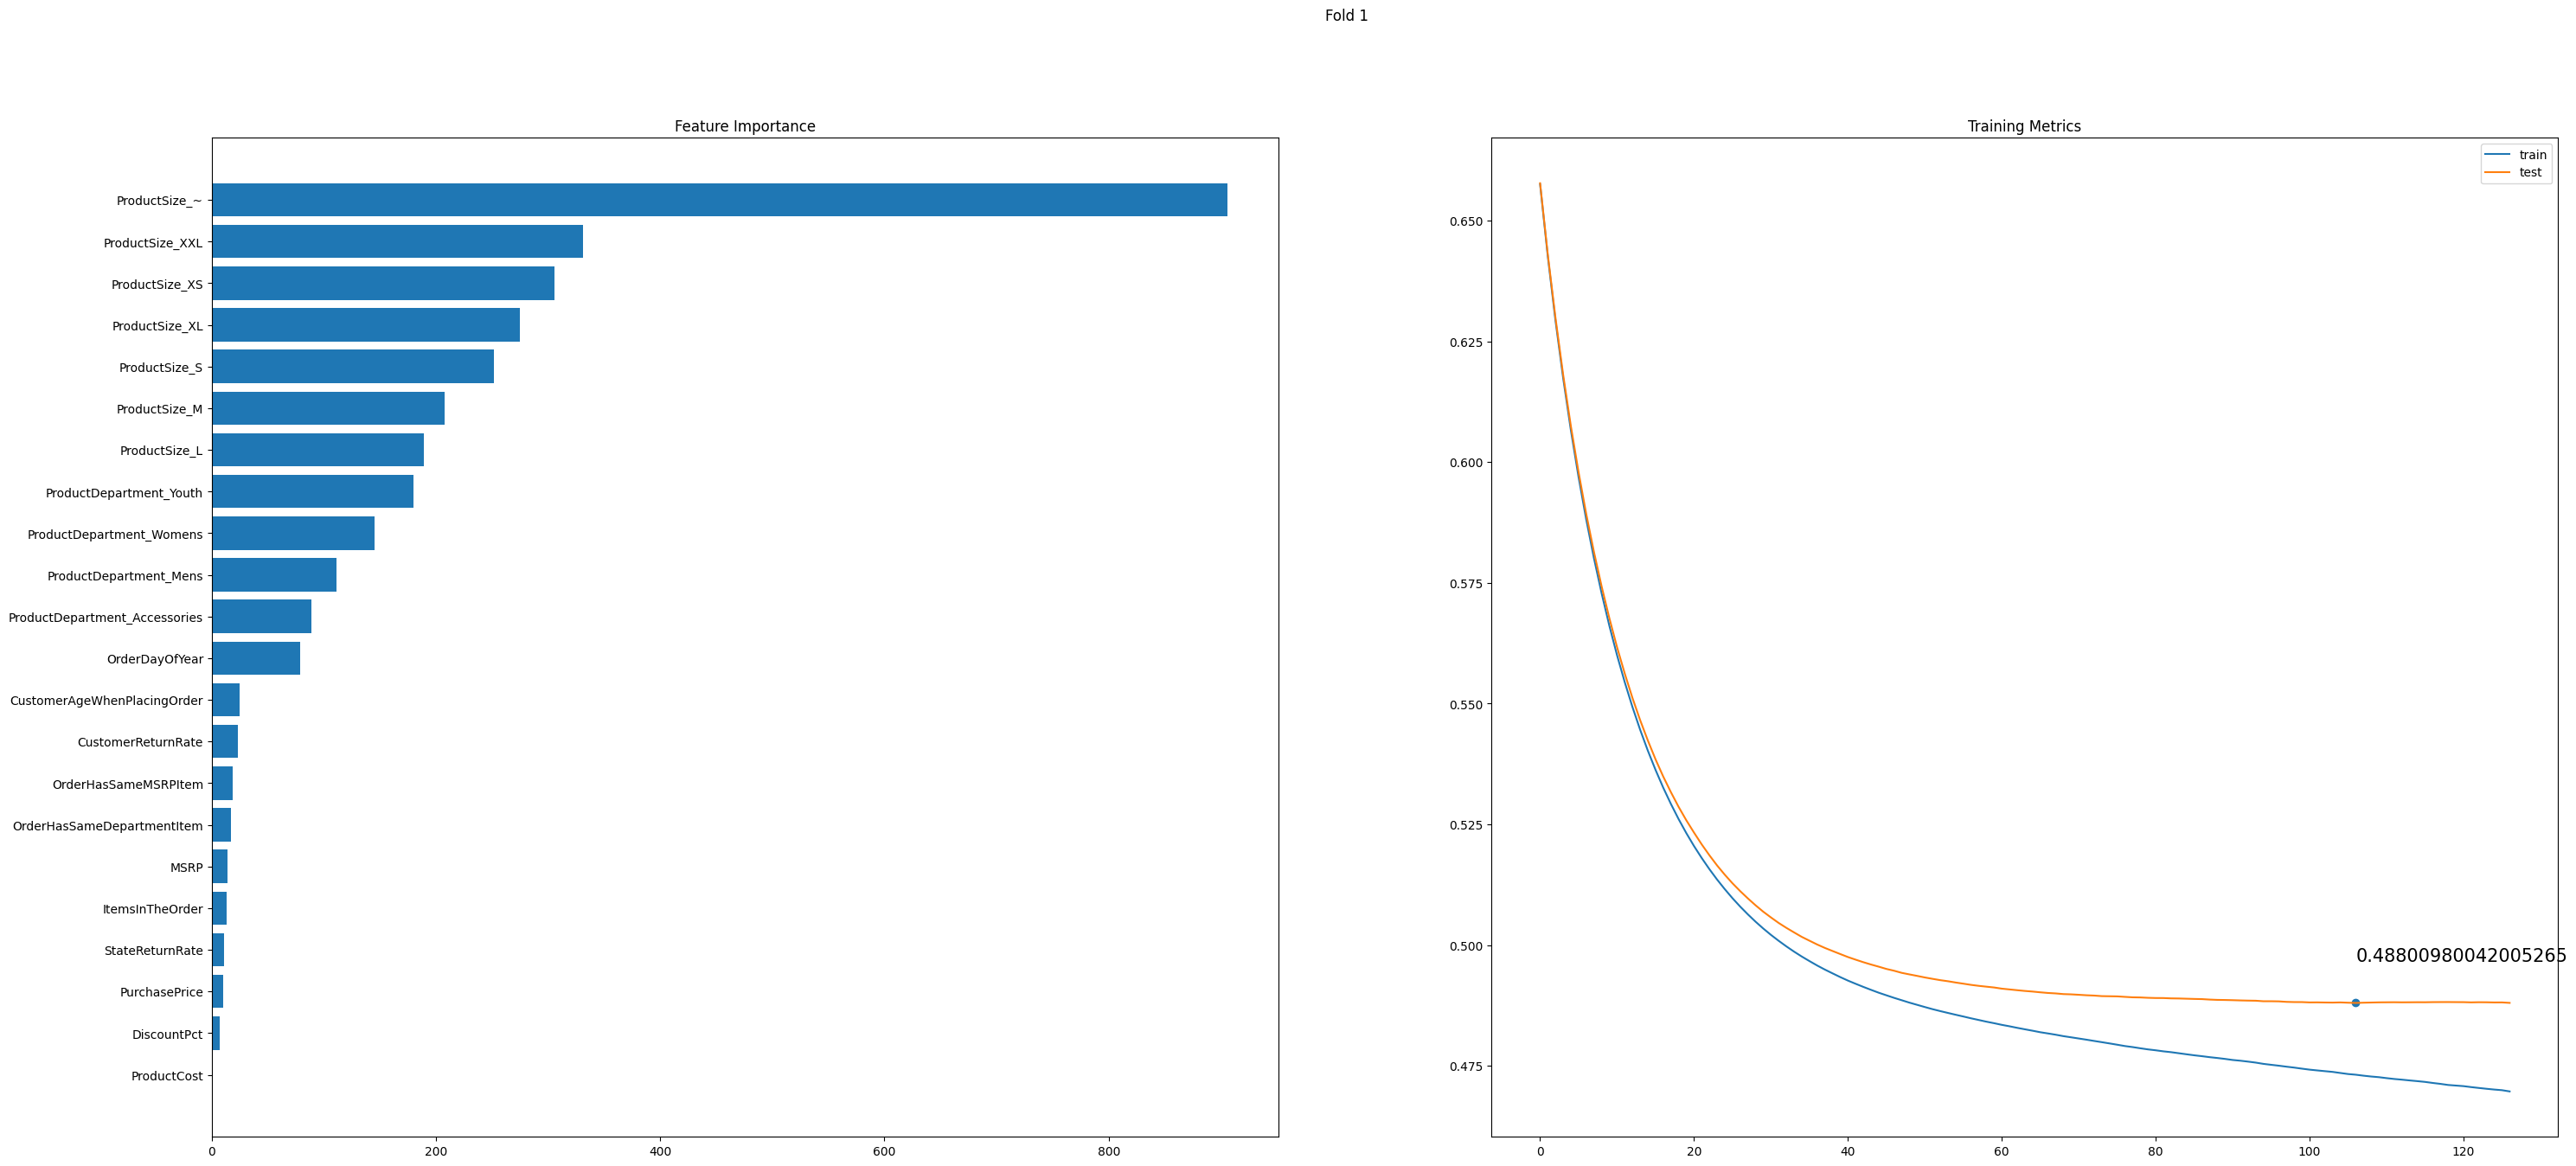

[LightGBM] [Info] Number of positive: 18301, number of negative: 33628
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005322 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1123
[LightGBM] [Info] Number of data points in the train set: 51929, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.352424 -> initscore=-0.608403
[LightGBM] [Info] Start training from score -0.608403


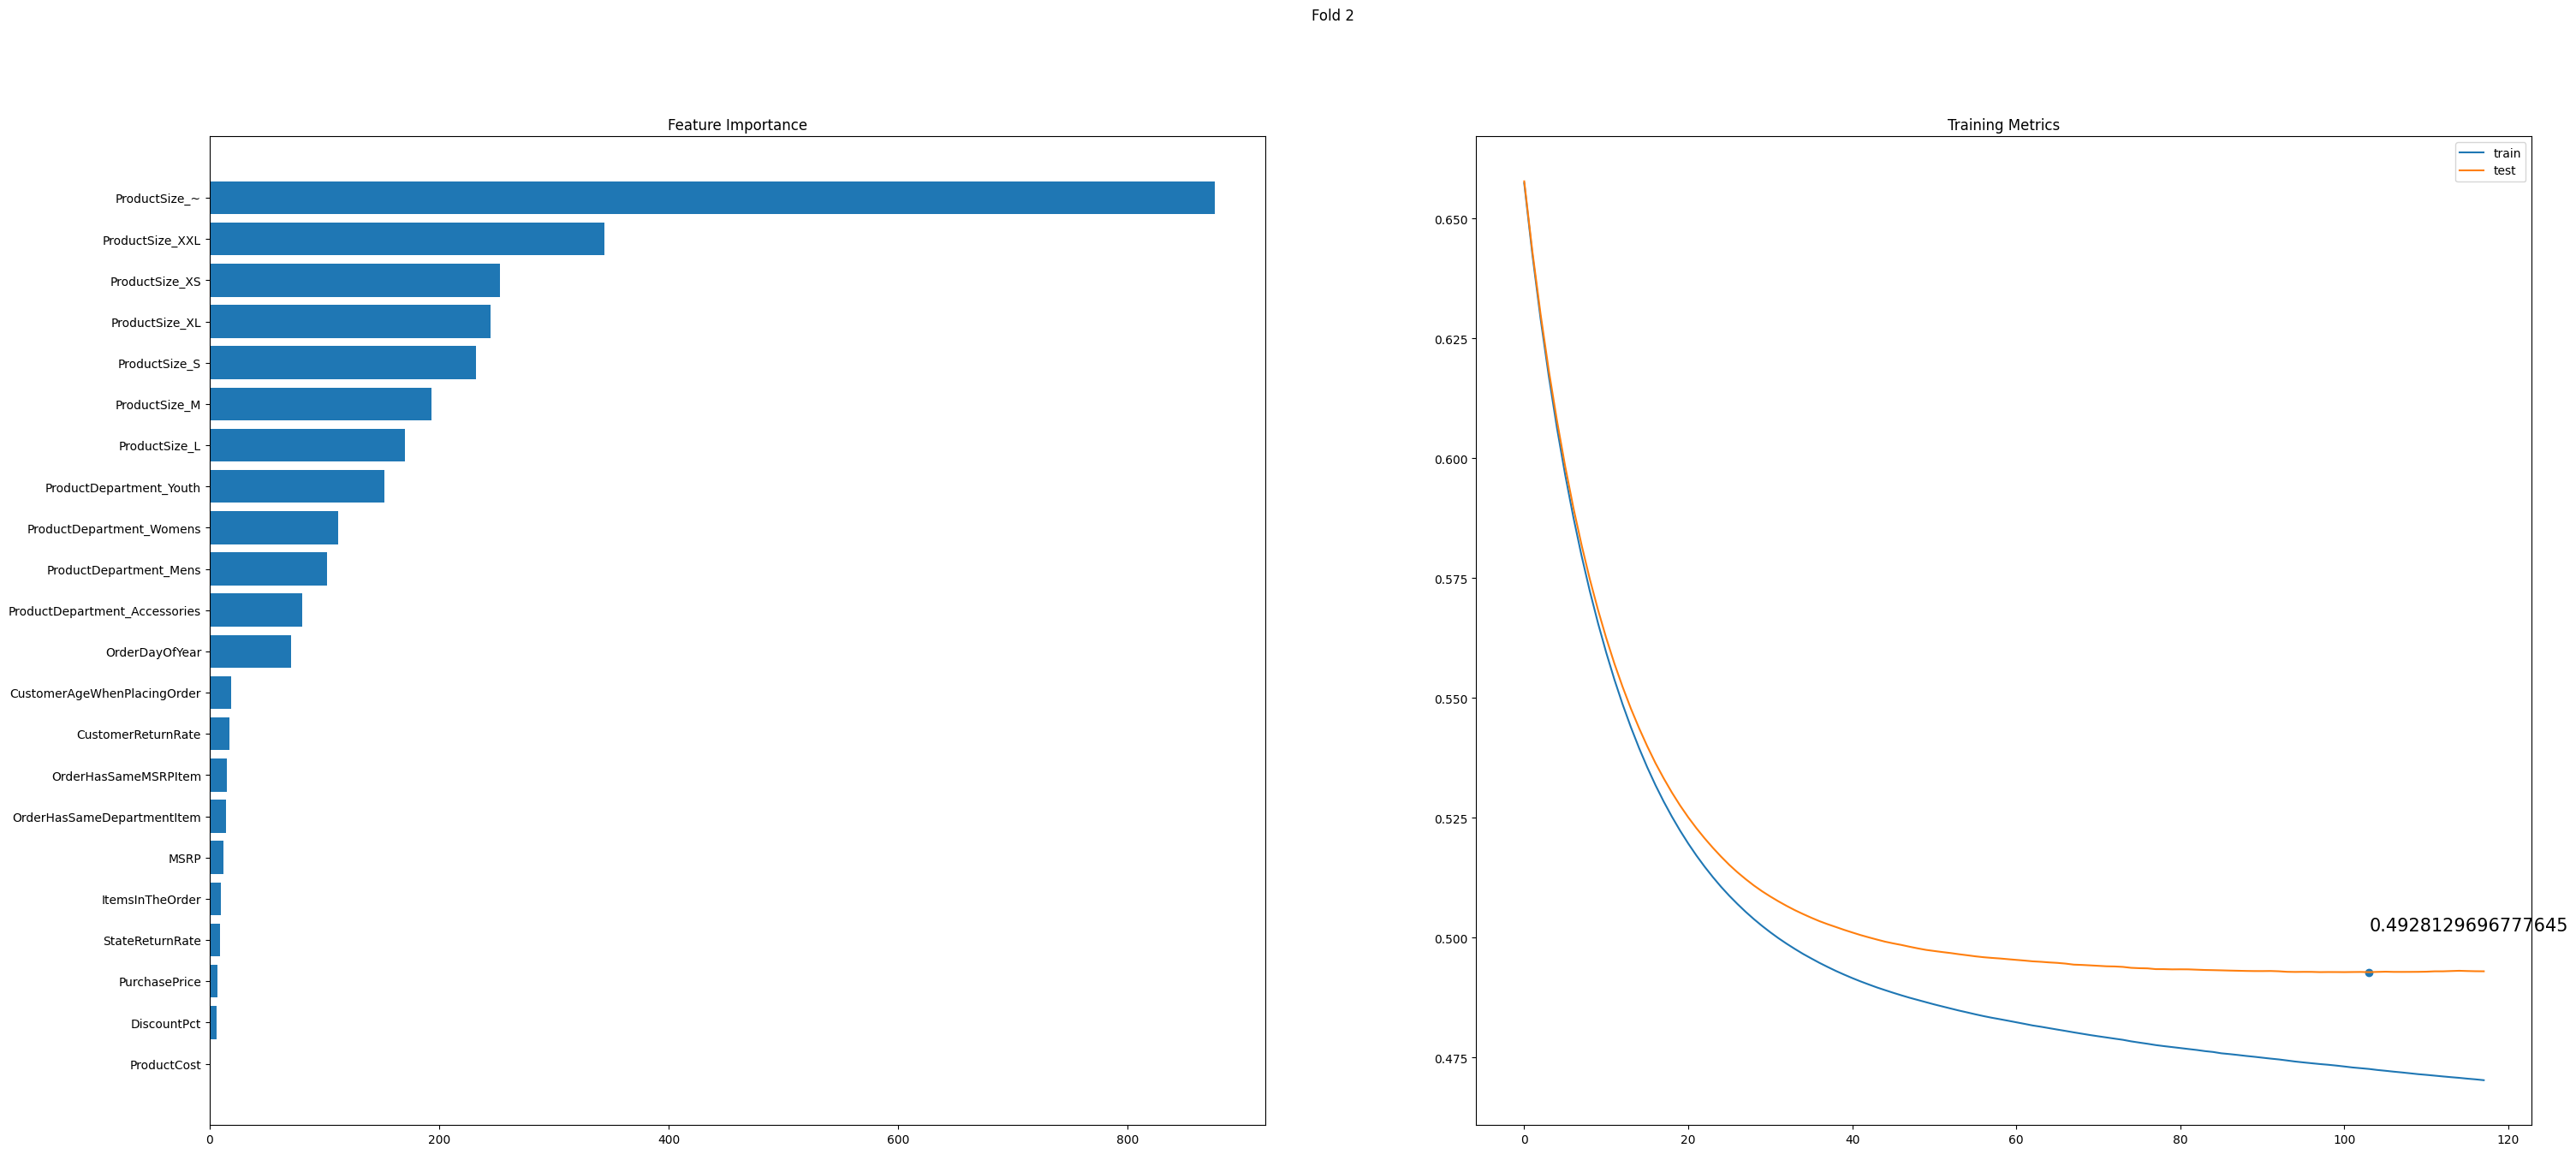

[LightGBM] [Info] Number of positive: 18302, number of negative: 33628
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004750 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1122
[LightGBM] [Info] Number of data points in the train set: 51930, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.352436 -> initscore=-0.608349
[LightGBM] [Info] Start training from score -0.608349


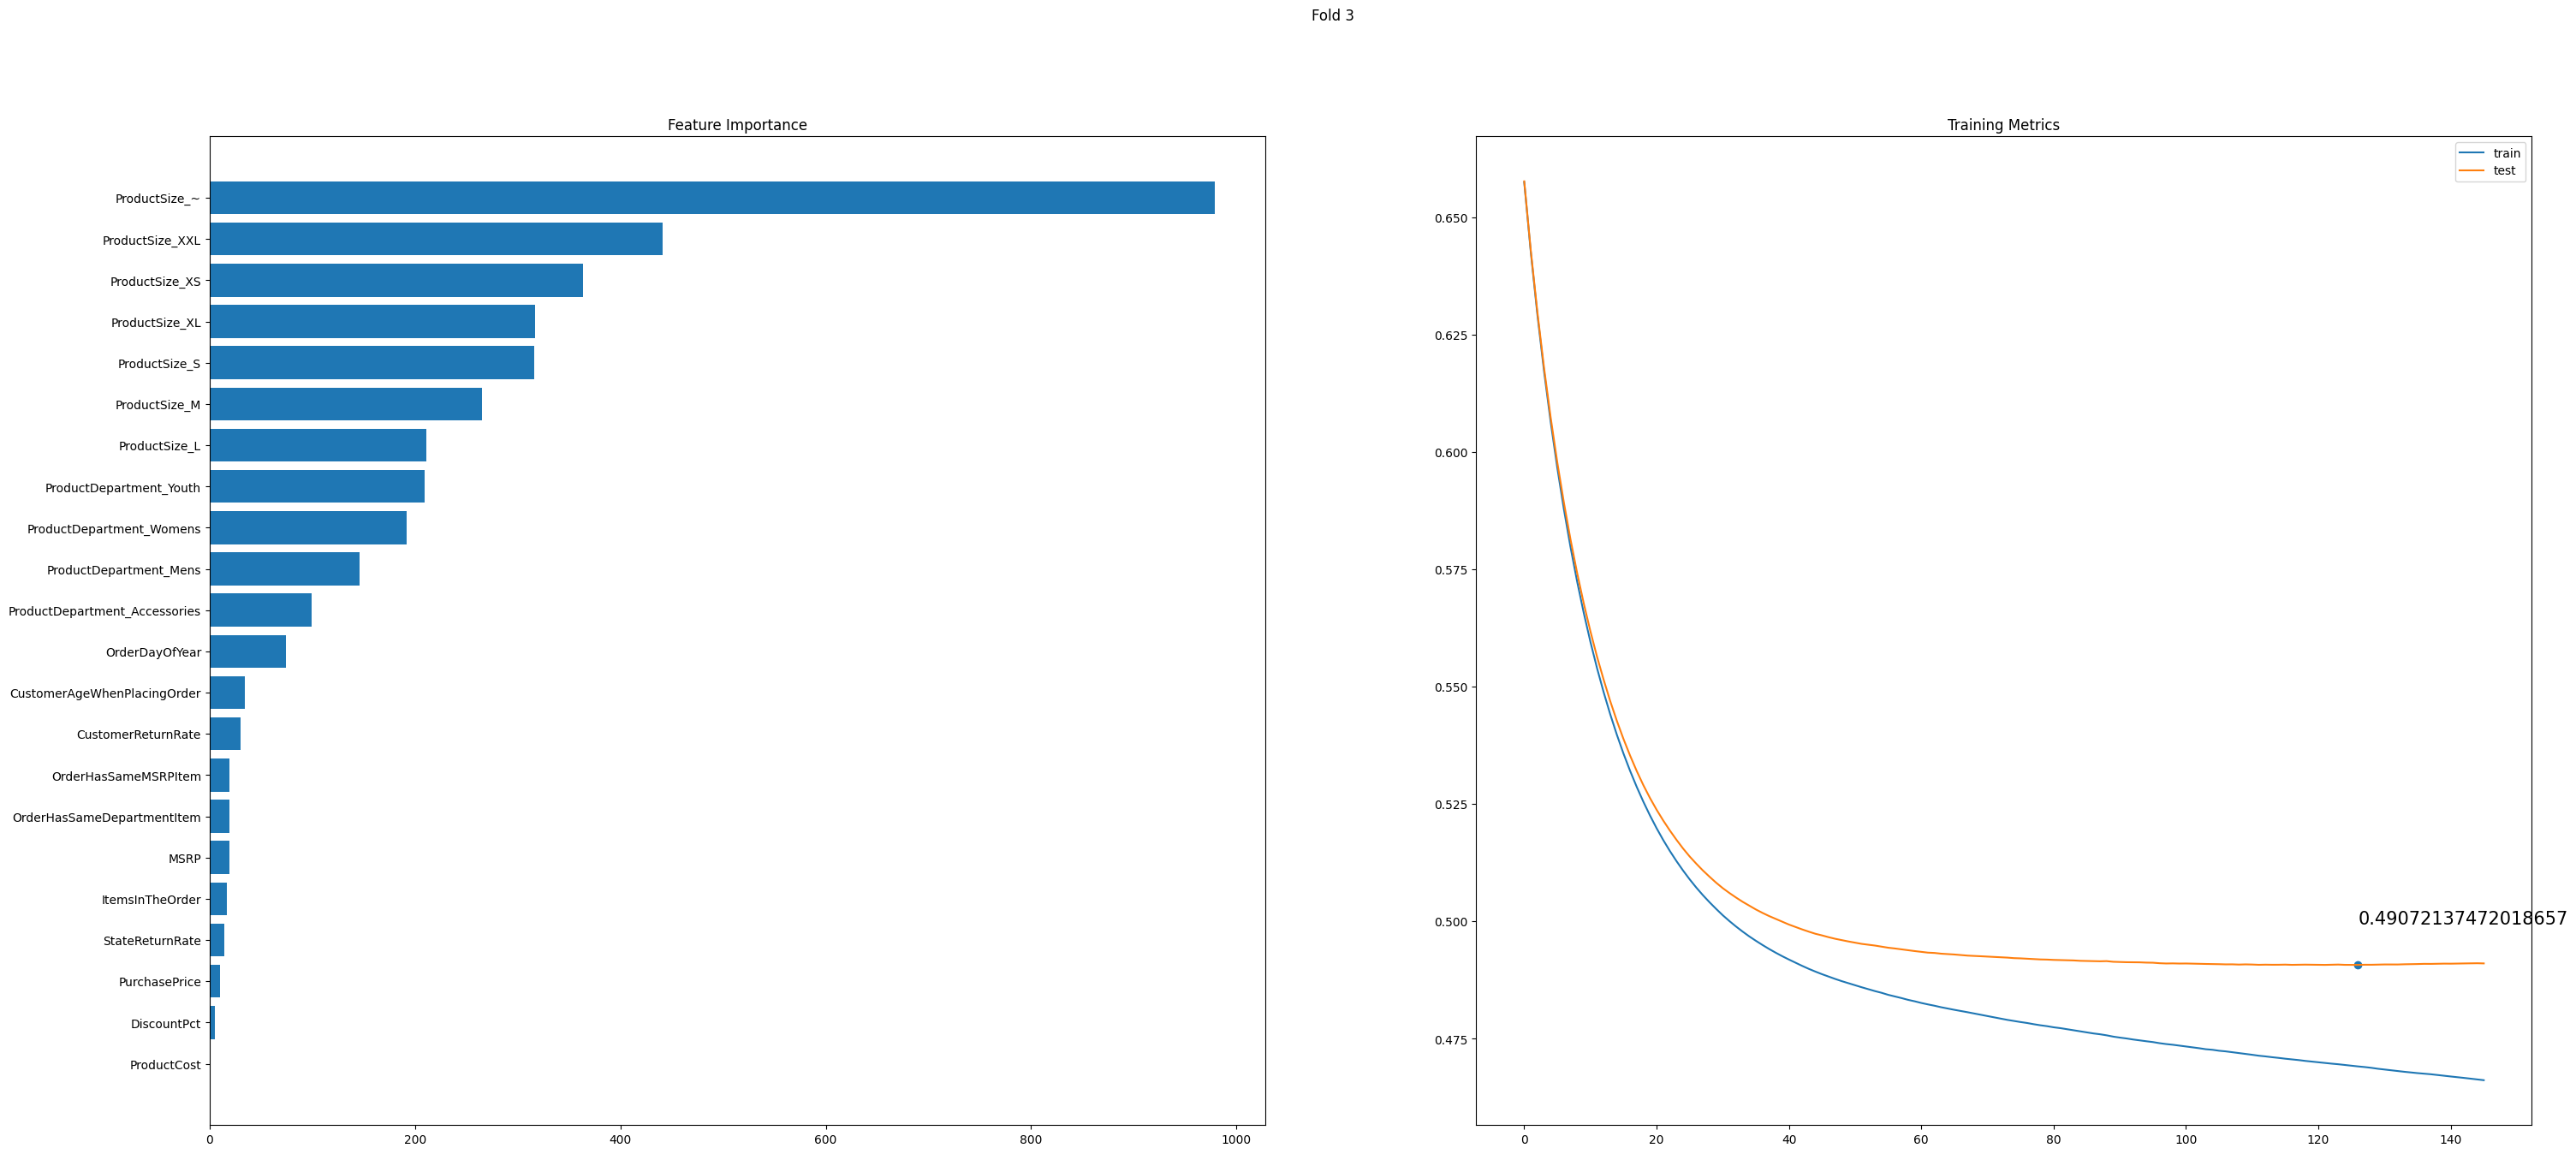

[LightGBM] [Info] Number of positive: 18302, number of negative: 33628
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004791 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1123
[LightGBM] [Info] Number of data points in the train set: 51930, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.352436 -> initscore=-0.608349
[LightGBM] [Info] Start training from score -0.608349


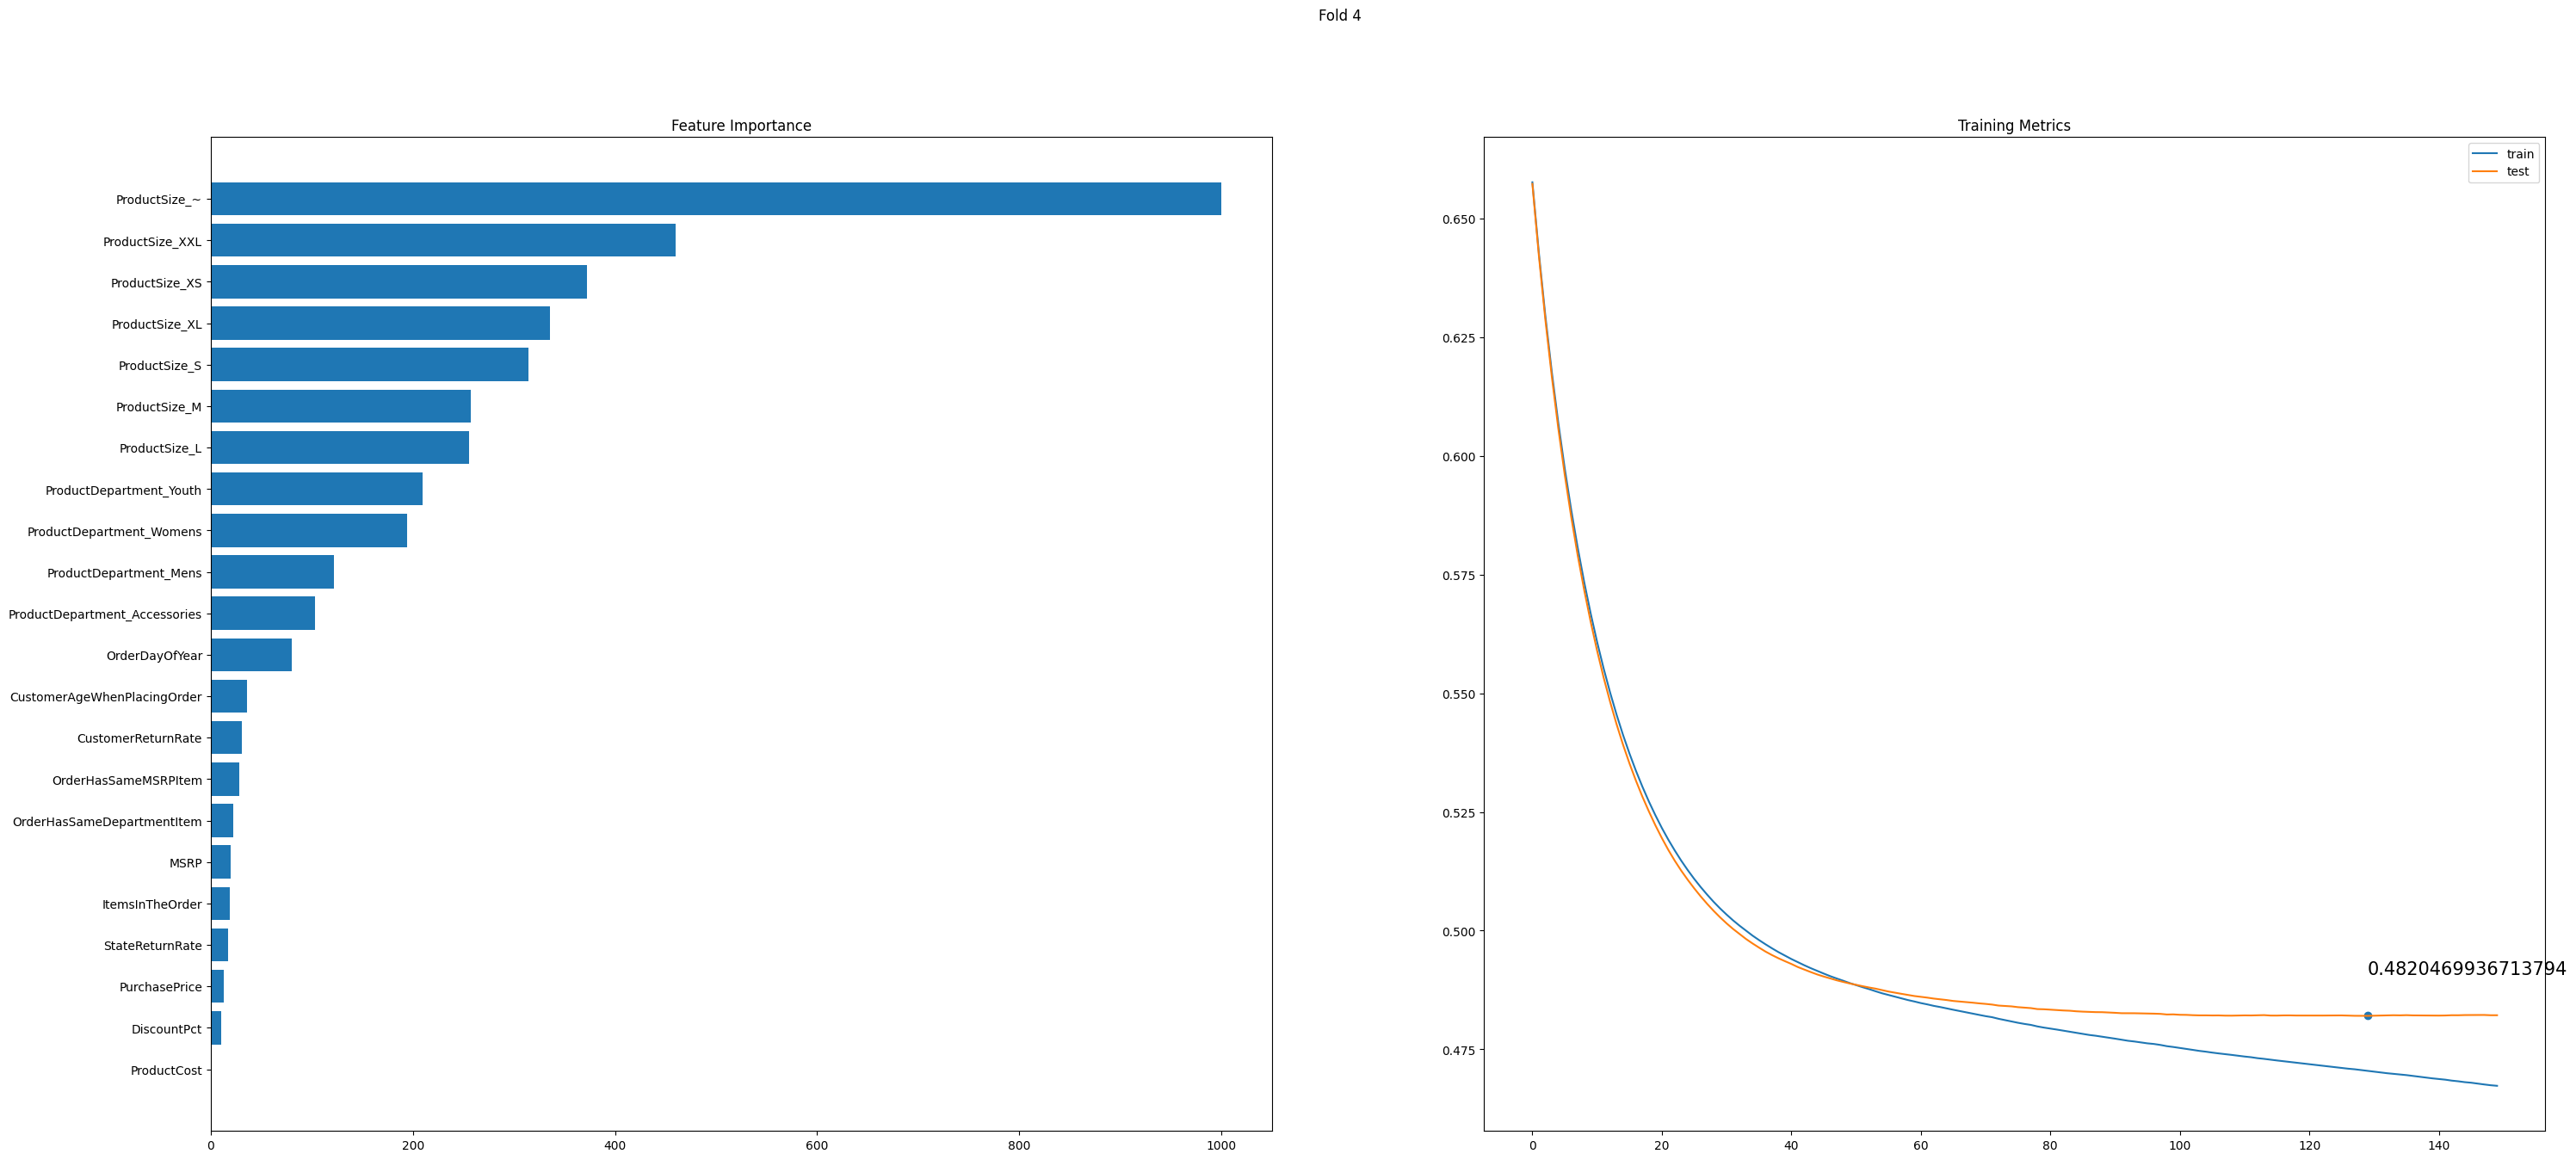

[LightGBM] [Info] Number of positive: 18302, number of negative: 33628
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005170 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1120
[LightGBM] [Info] Number of data points in the train set: 51930, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.352436 -> initscore=-0.608349
[LightGBM] [Info] Start training from score -0.608349


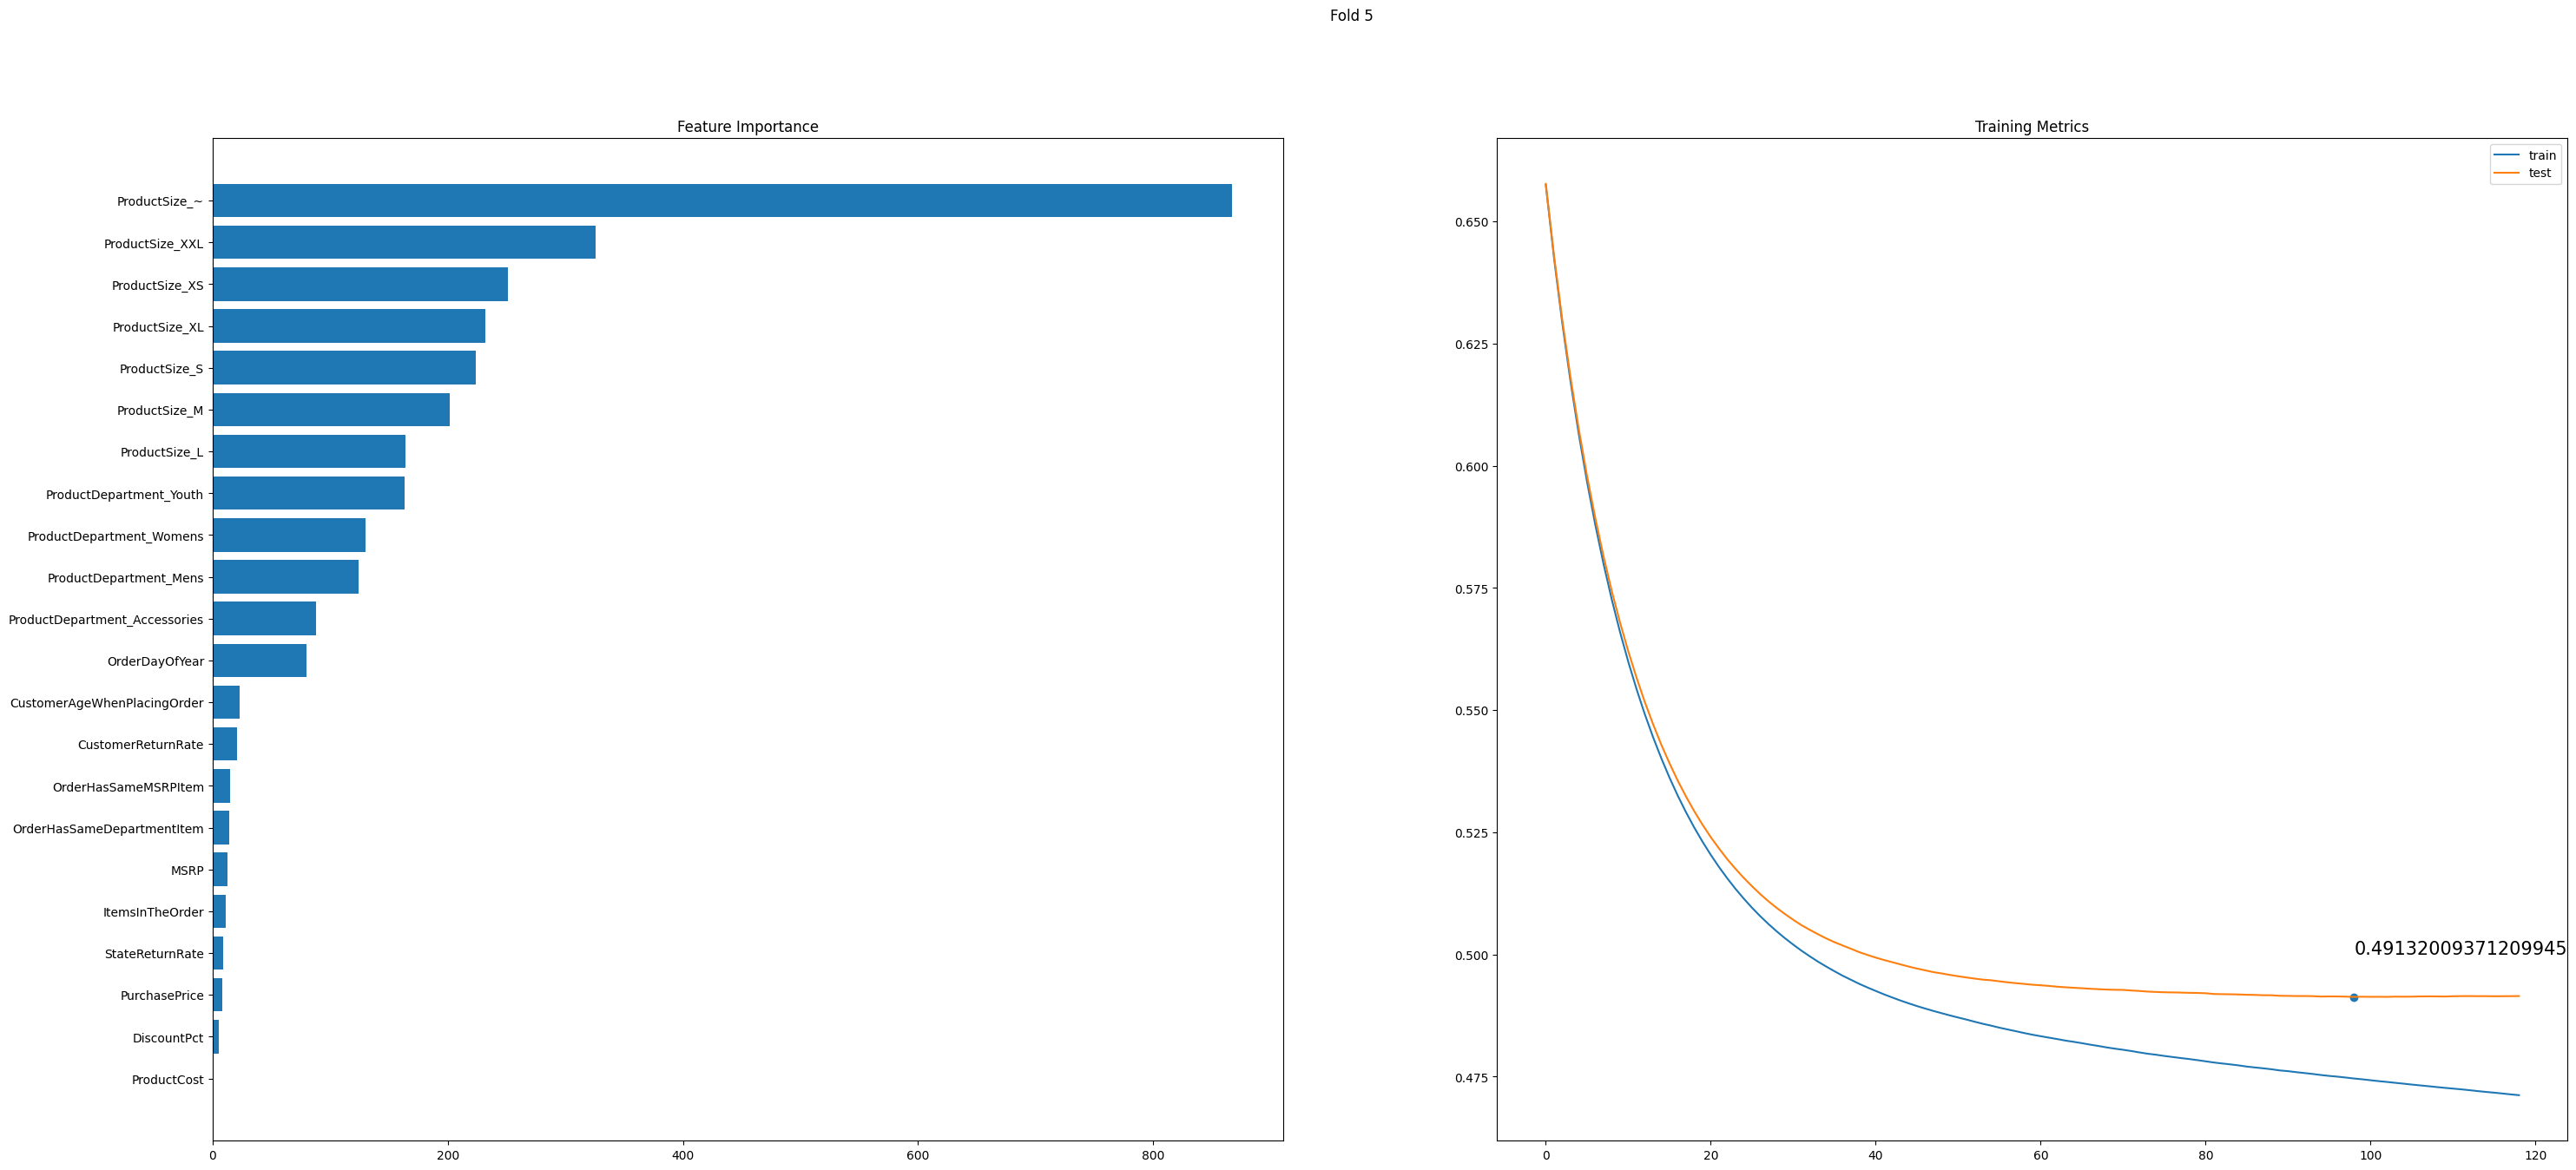

0.4820759321451683


In [21]:
def train_lgbm(X, y):
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    best_score = np.inf
    callbacks = [lgb.early_stopping(20, verbose=0), lgb.log_evaluation(period=0)]

    for i, (train_index, test_index) in enumerate(skf.split(X, y)):
        X_train, y_train = X[train_index], y[train_index]
        X_val, y_val = X[test_index], y[test_index]
        
        unique, counts = np.unique(y_train, return_counts=True)
        scale_pos_weight = np.sqrt(counts[0]/counts[1])

        model = lgb.LGBMClassifier(n_estimators=5000,
                                   learning_rate=0.05,
                                   scale_pos_weight=scale_pos_weight,                         
                                   objective='binary')
        

        model.fit(X_train, y_train,
                  eval_metric=lgbm_balanced_log_loss,
                  eval_set=[(X_train, y_train), (X_val, y_val)],
                  callbacks=callbacks
                 )


        results = model.evals_result_

        best_iteration = model.best_iteration_
        min_score = results['valid_1']['balanced_log_loss'][best_iteration]

        if min_score < best_score:
            best_score = min_score
            dump(model, 'lgbm.sav')

        fig ,axs = plt.subplots(1, 2, figsize=(35, 15))
        fig.suptitle(f'Fold {i+1}')

        sorted_idx = model.feature_importances_.argsort()
        axs[0].barh(FEATURES, model.feature_importances_[sorted_idx])
        axs[0].set_title('Feature Importance')
        
        metric_score = min(results['valid_1']['balanced_log_loss'])
        metric_index = results['valid_1']['balanced_log_loss'].index(min(results['valid_1']['balanced_log_loss']))

        
        axs[1].plot(results['training']['balanced_log_loss'], label='train')
        axs[1].plot(results['valid_1']['balanced_log_loss'], label='test')
        axs[1].scatter(x=metric_index, y=metric_score)
        axs[1].text(metric_index, metric_score+0.008, str(metric_score), va='bottom', fontsize=15)
        axs[1].set_title(f'Training Metrics')
        axs[1].legend()

        plt.show()
    
    return best_score
lgbm_best_score = train_lgbm(X, y)
print(lgbm_best_score)

In [22]:
xgb = load("xgb.sav")
lgbm = load("lgbm.sav")
test.drop('Returned', axis = 1, inplace = True)

for i, row in test.iterrows():
    batch = row.to_numpy()
    batch = batch[np.newaxis, :]
    xgb_pred = xgb.predict_proba(batch).squeeze()
    lgbm_pred = lgbm.predict_proba(batch).squeeze()

    submission.at[i, 'Returned'] = (xgb_pred[1] * 0.5) + (lgbm_pred[1] * 0.5)

submission.to_csv('Transactions/submission.csv', index = False)
print(submission)

                                         ID  Returned
0      a6f6ecd9-2c08-4363-baf7-b54adc35d486  0.217008
1      e819be63-7a98-4e6d-b217-03f9ac8c1d03  0.829393
2      8936a1c6-f5eb-4c78-9636-e693aae49d9f  0.749245
3      68b74b1d-deab-4d93-bfe8-859d450952ef  0.743430
4      657abc10-0b36-49df-b3ae-a1a6b9d1d145  0.221433
...                                     ...       ...
14804  1054eac9-20f8-407a-98c2-c46babba7fb0  0.470571
14805  cddb17d5-c4a9-4d8c-a840-cc67f366439d  0.844021
14806  7c96d4c5-f5c7-4e36-a5d8-c49bfc215705  0.844021
14807  68056d93-88d9-4ad1-b2cf-9f6cc8d10bcc  0.258238
14808  39b58e15-bb6c-45c5-89f0-c6c10492a26b  0.233350

[14809 rows x 2 columns]
